In [84]:
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [136]:
b32 = 2**32-1
b64 = 2**64-1

# Map of asset to maximum nonce value, used later for plotting
assets_to_range = {
    "btc": b32,
    "bch": b32,
    "vtc": b32,
    "ltc": b32, 
    "xmr": b32, 
    "dcr": b32, 
    "grin": b64,
    "eth": b64,
    "etc": b64,
    "xvg": b32,
    "dgb": b32,
}

# given a number, return a list of n bits ([0, 1, 1, ...])
def to_bits(number, n):
    return [int(x) for x in bin(number)[2:].zfill(n)]

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [122]:
from math import log

def query_nonces(table):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT nonce FROM {table} ORDER BY height ASC")
            return list(map(lambda x: int(x[0]), cursor.fetchall()))

def get_ethereum_nonces(table):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT ENCODE(nonce, 'hex') FROM {table} ORDER BY number ASC")
            return list(map(lambda x: int(x[0], 16), cursor.fetchall()))
        
def get_nonces(asset):
    if asset == "btc":
        return query_nonces("bitcoin")
    elif asset == "ltc":
        return query_nonces("litecoin")
    elif asset == "xmr":
        return query_nonces("monero")
    elif asset == "dcr":
        return query_nonces("decred")
    elif asset == "grin":
        return query_nonces("grin")
    elif asset == "eth":
        return get_ethereum_nonces("ethereum")
    elif asset == "etc":
        return get_ethereum_nonces("ethereum_classic")
    elif asset == "xvg":
        return query_nonces("verge")
    elif asset == "vtc":
        return query_nonces("vertcoin")
    elif asset == "bch":
        return query_nonces("bitcoin_abc")
    elif asset == "dgb":
        return query_nonces("digibyte")
        
    raise NotImplementedError(asset)

In [132]:
nonces = {symbol: get_nonces(symbol) for symbol in assets_to_range.keys()}

In [195]:
sns.set(rc={'figure.figsize':(10,4), 'figure.dpi': 100})

def plot_distribution(asset, n_bins=200):
    sns.set_style("white")
    
    plt.title(f"{asset} nonce histogram")
    max_x = assets_to_range[asset]
    data = nonces[asset]
    plt.xlim(0, max_x)
    ax = sns.distplot(data, kde=False, bins=n_bins, hist_kws={"histtype": "bar", "color": "b"})
    # We need to compute the expected number of blocks per bin
    # and display it as a horizontal line
    n_expected_blocks = len(data) / n_bins
    ax.axhline(y=n_expected_blocks, xmin=0.0, xmax=1, color='r', ls='--', lw=1)
    plt.xlabel("Nonce value")
    plt.ylabel("# of blocks")
    plt.show()
    
def plot(asset, alpha=None):
    max_x = assets_to_range[asset]
    data = nonces[asset]
    
    # for forks, we put a vertical bar at the fork height
    fork_height = {
        "bch": 478559,
        "bsv": 556766,
        "etc": 1920000,
    }
    
    n_blocks = len(data)
    # Simple heuristic to have a somewhat correct alpha no matter the density
    alpha_value = n_blocks / 10000000. if alpha is None else alpha
    plt.figure(figsize=(10,4), dpi=100)
    plt.xlabel("Block height")
    plt.ylabel("Nonce value")
    plt.title(f"{asset} nonce distribution")
    plt.ylim(0, max_x)
    plt.xlim(0, n_blocks)
    plt.plot(data, ',', alpha=alpha_value)
    if asset in fork_height:
        plt.axvline(fork_height[asset], 0, 1, color='r', ls='solid', lw=1)
        
    plt.show()
    
def heatmap(asset, bin_size, bits):
    sns.set_style("white")
    
    data = []
    # split nonces into bin_size chunks
    for chunk in chunks(nonces[asset], bin_size):
        n = len(chunk)
        # row collects how many time bits are set
        row = [0] * bits
        for nonce in chunk:
            # transform nonce into bit representation
            binary = to_bits(nonce, bits)
            # and collect when bits are set
            for i, bit in enumerate(binary):
                row[i] += bit
        # transform the row into %
        row = [i / n for i in row[:-1]]
        data.append(row)
        
    sns.heatmap(np.array(data).T, xticklabels=False)

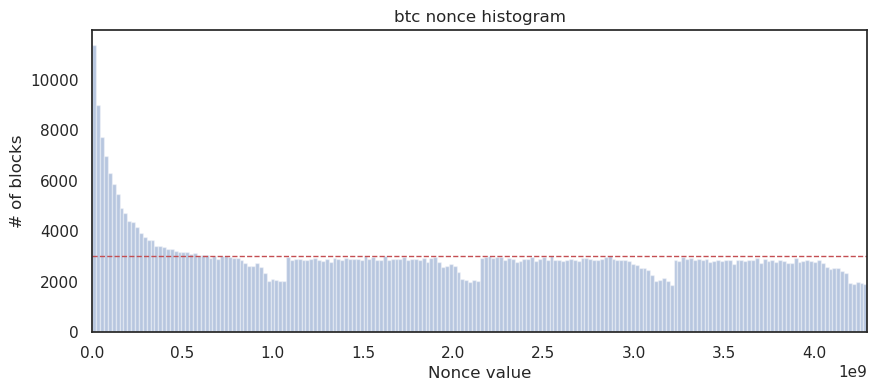

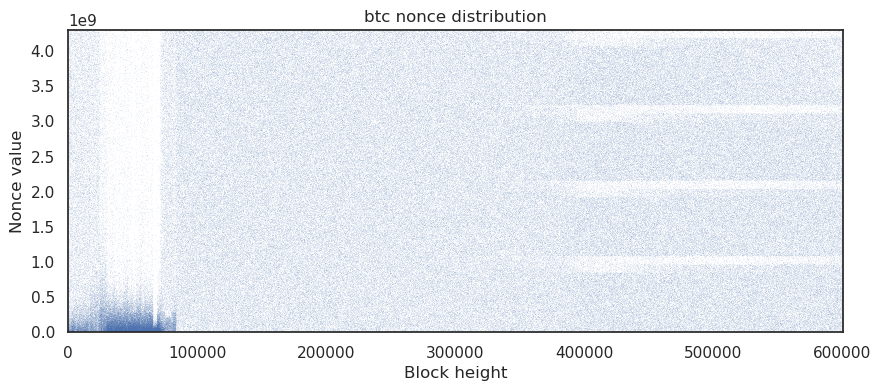

In [125]:
plot_distribution("btc")
plot("btc")

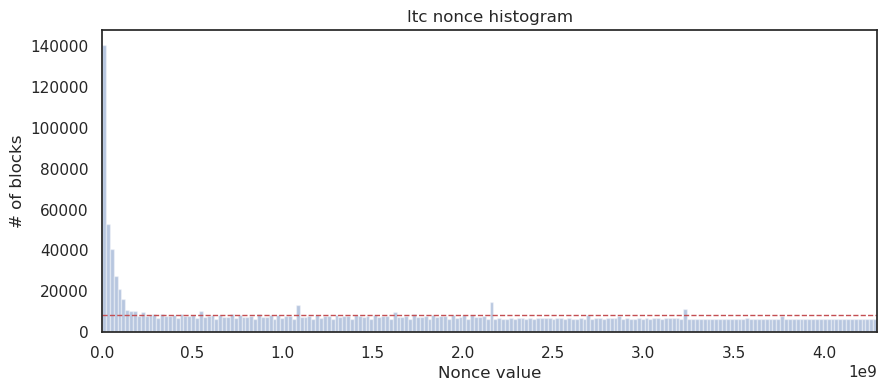

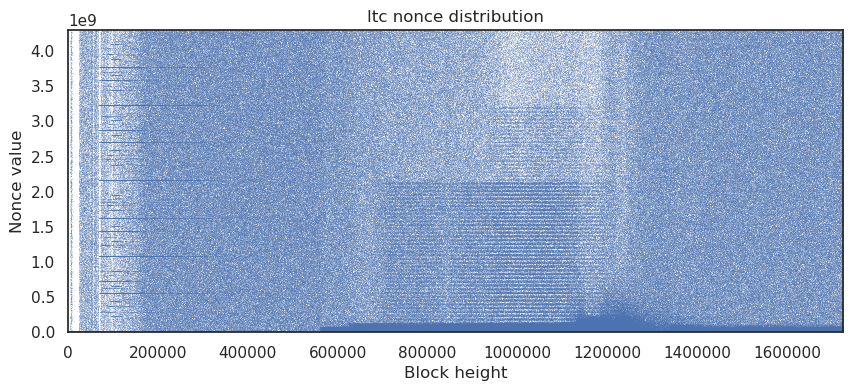

In [126]:
plot_distribution("ltc")
plot("ltc")

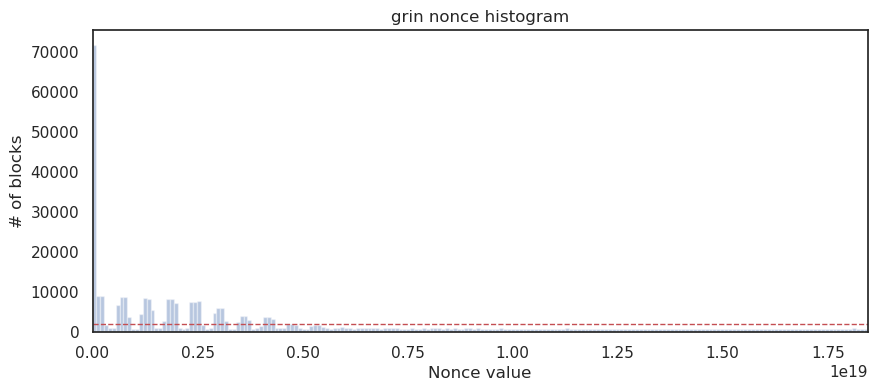

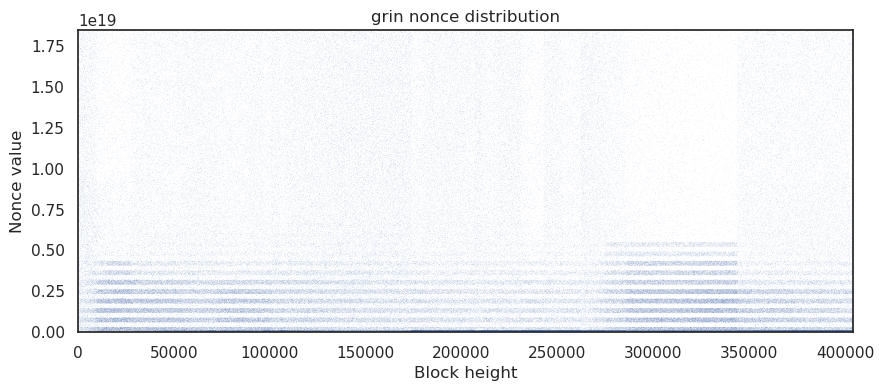

In [127]:
plot_distribution("grin")
plot("grin")

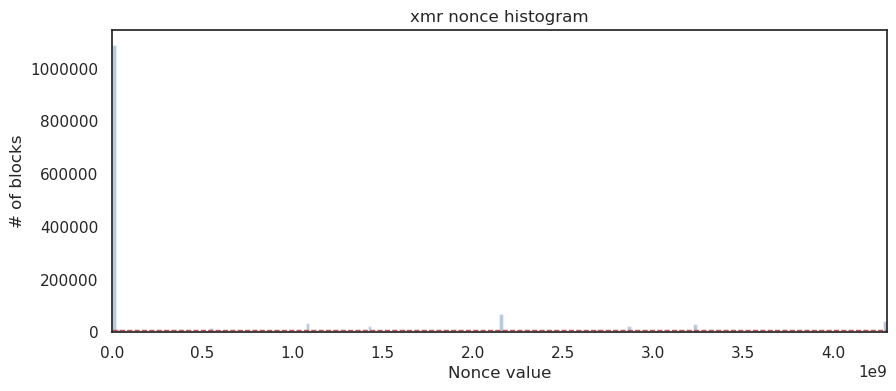

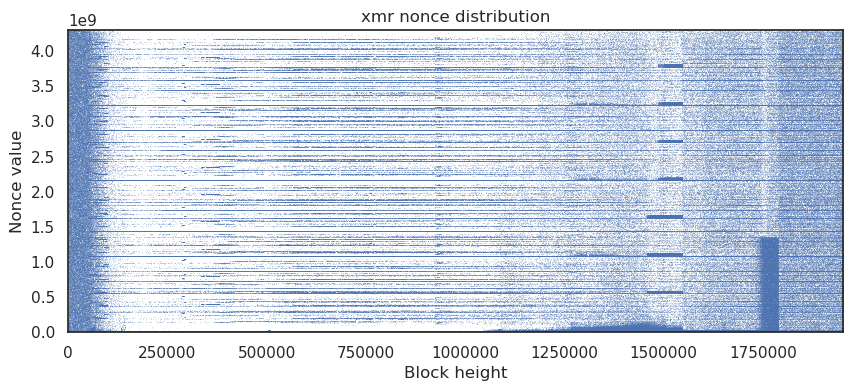

In [128]:
plot_distribution("xmr")
plot("xmr")

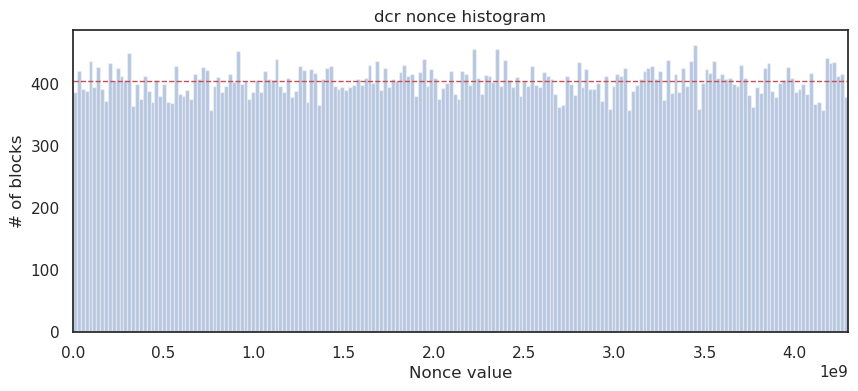

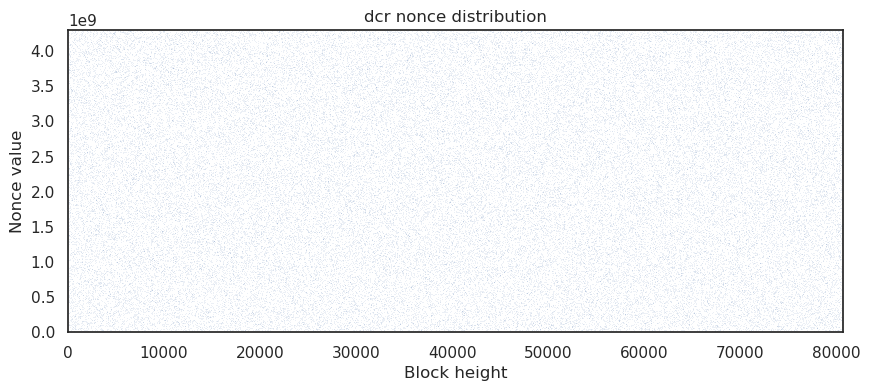

In [129]:
plot_distribution("dcr")
plot("dcr", alpha=0.1)

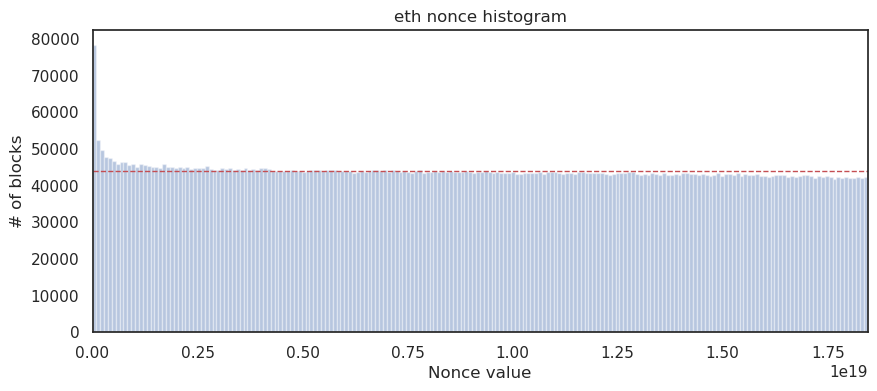

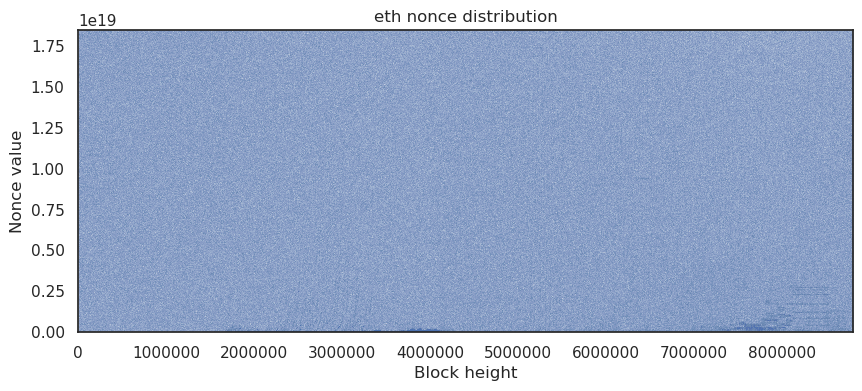

In [133]:
plot_distribution("eth")
plot("eth", alpha=0.025)

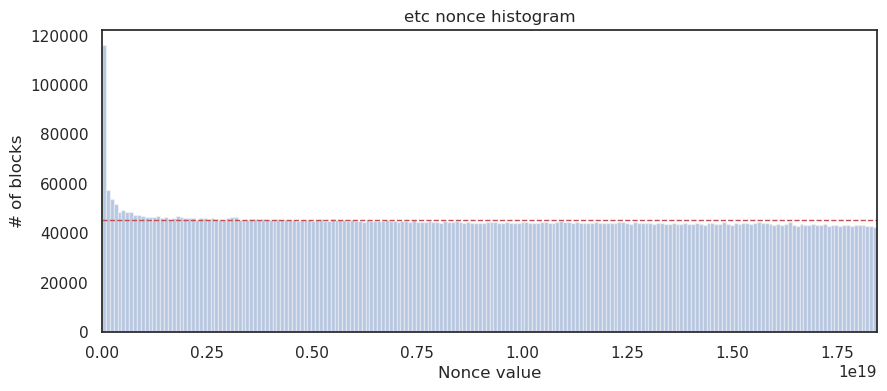

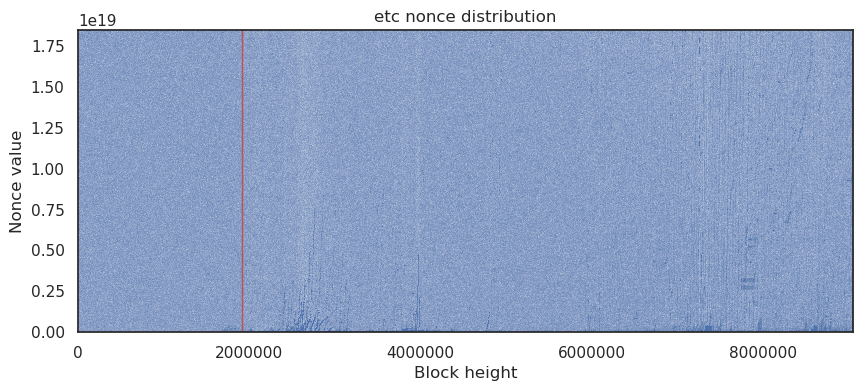

In [134]:
plot_distribution("etc")
plot("etc", alpha=0.025)

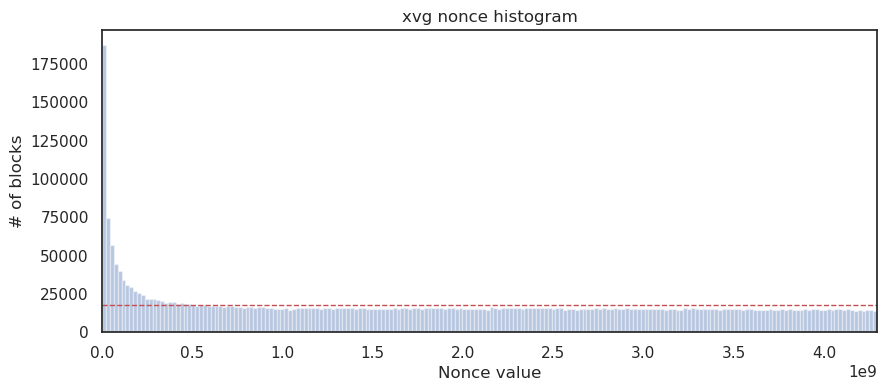

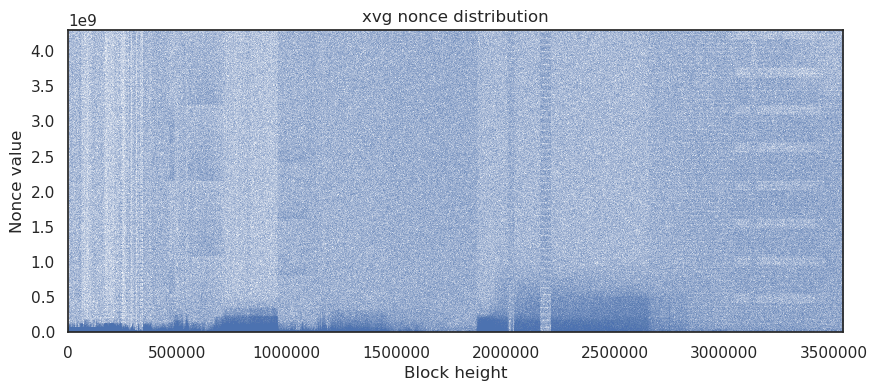

In [37]:
plot_distribution("xvg")
plot("xvg", alpha=0.05)

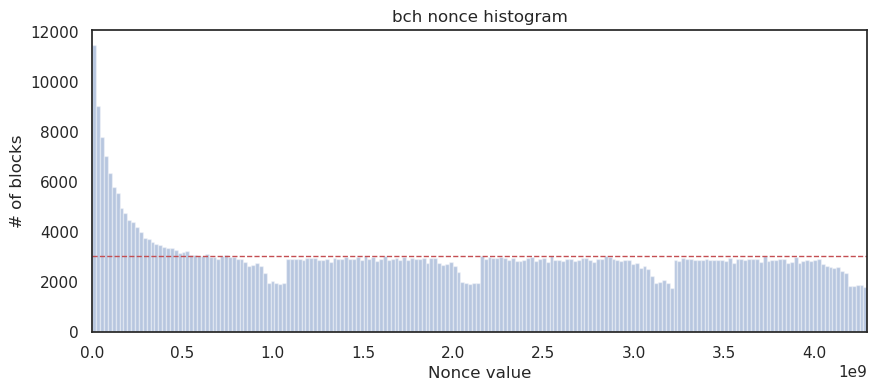

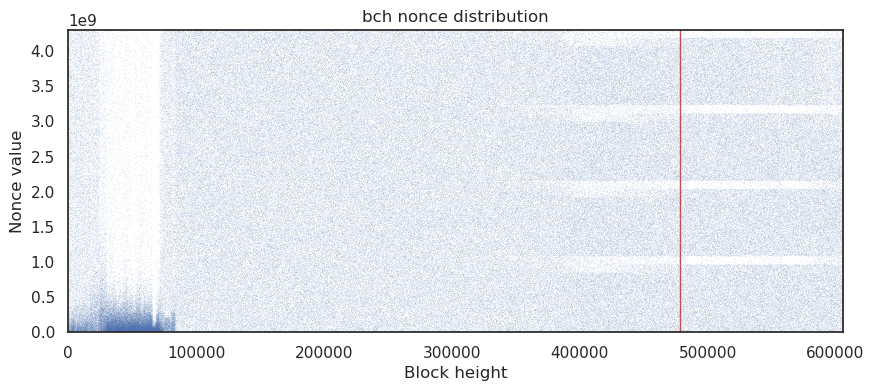

In [38]:
plot_distribution("bch")
plot("bch")

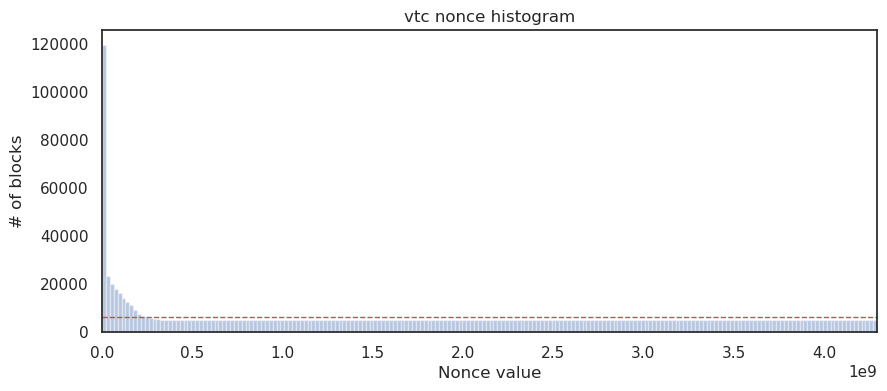

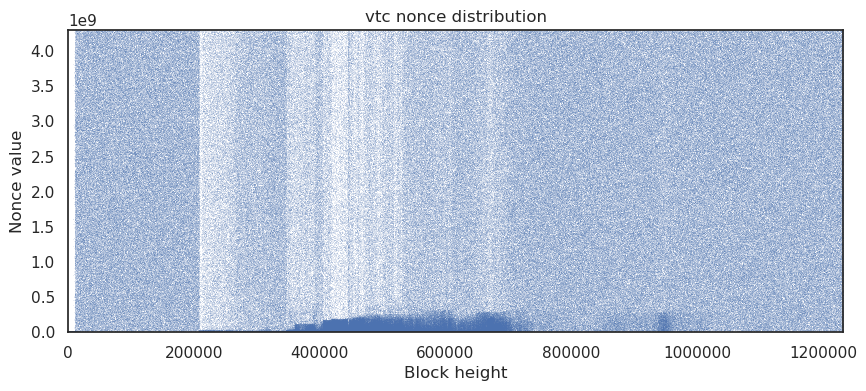

In [40]:
plot_distribution("vtc")
plot("vtc")

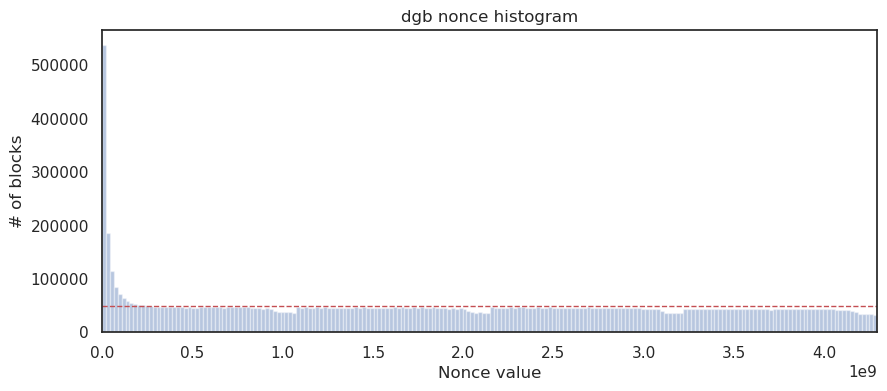

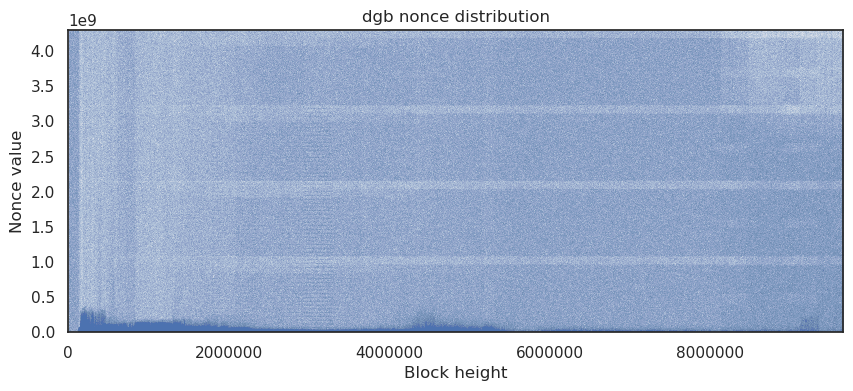

In [48]:
plot_distribution("dgb")
plot("dgb", alpha=0.02)

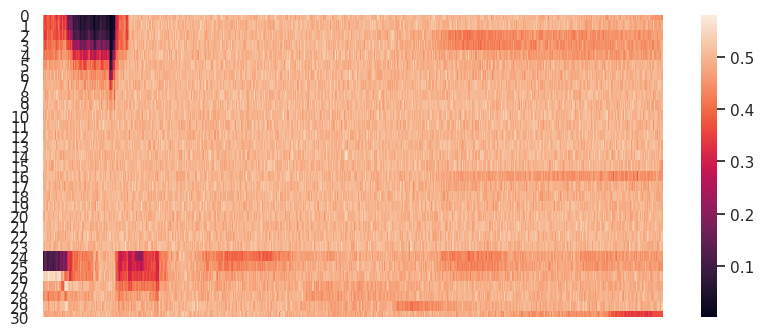

In [194]:
heatmap("btc", 1000, 32)

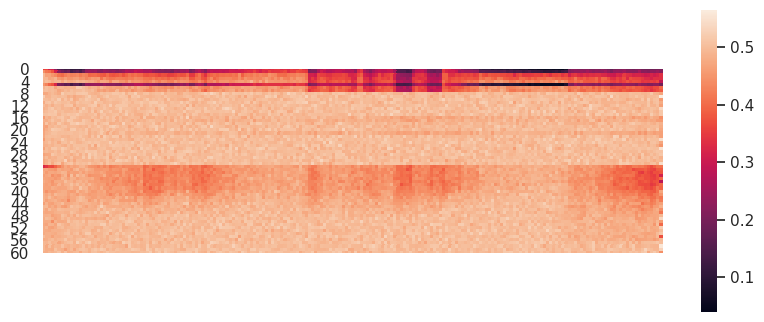

In [179]:
heatmap("grin", 2000, 64)

AttributeError: 'QuadMesh' object has no property 'xtickslabels'

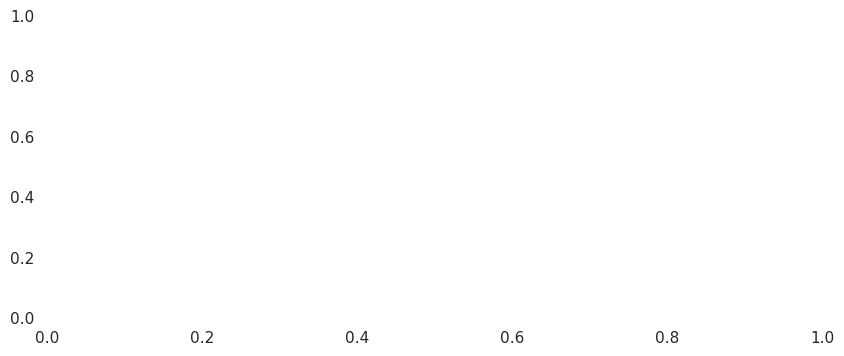

In [174]:
heatmap("xmr", 1000, 32)

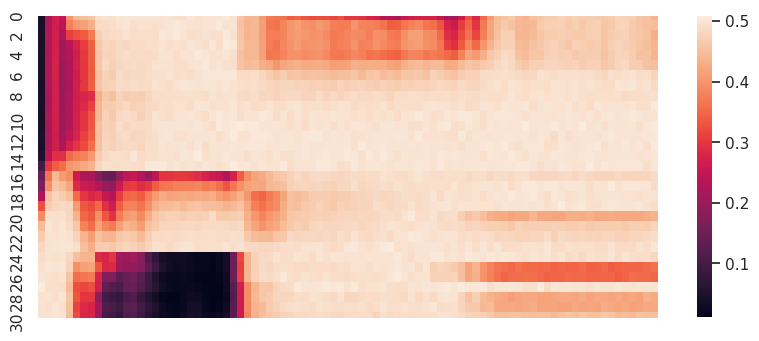

In [181]:
heatmap("ltc", 20000, 32)